# Diagnosing Chronic Kidney Disease

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')
data = df

In [4]:
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


# Data Mapping

In [5]:
data['class'] = data['class'].map({'ckd':1,'notckd':0})
data['htn'] = data['htn'].map({'yes':1,'no':0})
data['dm'] = data['dm'].map({'yes':1,'no':0})
data['cad'] = data['cad'].map({'yes':1,'no':0})
data['appet'] = data['appet'].map({'good':1,'poor':0})
data['ane'] = data['ane'].map({'yes':1,'no':0})
data['pe'] = data['pe'].map({'yes':1,'no':0})
data['ba'] = data['ba'].map({'present':1,'notpresent':0})
data['pcc'] = data['pcc'].map({'present':1,'notpresent':0})
data['pc'] = data['pc'].map({'abnormal':1,'normal':0})
data['rbc'] = data['rbc'].map({'abnormal':1,'normal':0})

In [6]:
data['class'].value_counts()

1    250
0    150
Name: class, dtype: int64

Factors that may increase your risk of chronic kidney disease include:

- Diabetes - su(blood sugar), dm (diabetes mellitus)
- High blood pressure - BP
- Heart and blood vessel (cardiovascular) disease
- Smoking
- Obesity
- Being African-American, Native American or Asian-American
- Family history of kidney disease
- Abnormal kidney structure
- Older age - age

<AxesSubplot:>

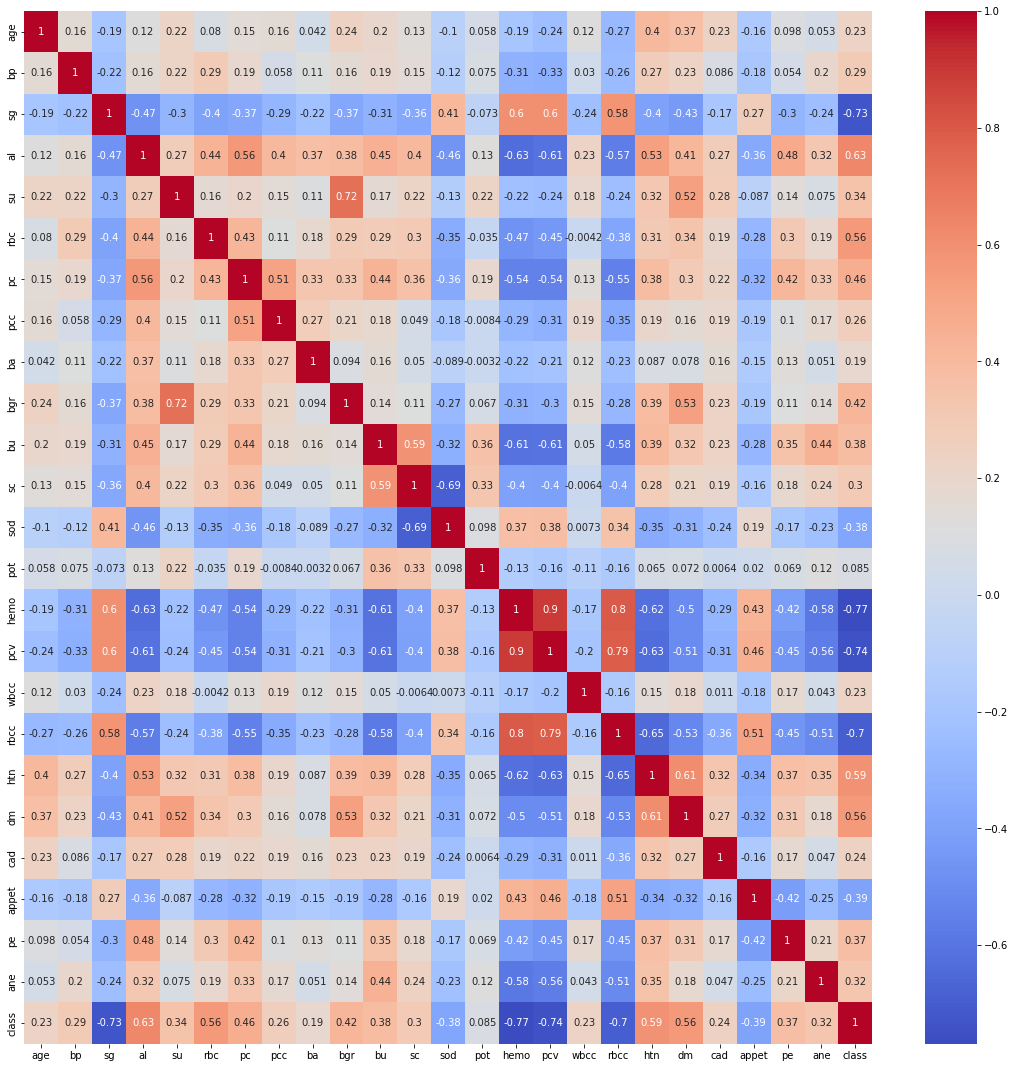

In [7]:
plt.figure(figsize = (19,19))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm') # looking for strong correlations with "class" row 

# EDA

In [8]:
data.shape

(400, 25)

In [9]:
data.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [10]:
data.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [11]:
data.shape[0], data.dropna().shape[0]

(400, 158)

We would only have 158 rows remaining if we drop the na columns.  One downside is that we reduce the overall power of our model when we feed in less data, and another is that we dont know if the fact that those values are null is related in some way to an additional variable.  If the latter is the case, throwing out that data could potentially skew our data.

I am going to drop in this case and see how the model performs.

Generally speaking in situations where we are providing patients with a diagnosis, we want to err on the side of false positives. In this specific case, a false negative would be telling a patient that is CKD-positive that they do not have CKD, and the result could be catastrophic if the mistake is not caught. This would be a "worse" mistake than telling someone who is CKD-negative that they have CKD, as they would be brought in for further testing and find out that they are actually CKD-negative

In [12]:
data.dropna(inplace=True)

In [13]:
data.shape

(158, 25)

# Modeling

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
logreg = LogisticRegression()

In [16]:
X = data.iloc[:,:-1]
y = data['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, shuffle = True)

In [18]:
logreg.fit(X_train,y_train)

C:\Users\ayush\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
test_pred = logreg.predict(X_test)
train_pred = logreg.predict(X_train)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [21]:
print('Train Accuracy: ', accuracy_score(y_train, train_pred))
print('Test Accuracy: ', accuracy_score(y_test, test_pred))

Train Accuracy:  1.0
Test Accuracy:  1.0


### The cell below shows the coefficients for each variable.
(example on reading the coefficients from a Logistic Regression: a one unit increase in age makes an individual about e^0.14 time as likely to have ckd, while a one unit increase in blood pressure makes an individual about e^-0.07 times as likely to have ckd.

In [22]:
pd.DataFrame(logreg.coef_, columns=X.columns)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,0.253135,-0.088636,0.005838,0.403973,0.007162,0.018022,0.124149,0.001396,0.004804,0.263135,...,-0.330147,-0.746547,0.001237,-0.150172,0.128902,0.128615,0.000979,0.00195,0.01012,0.001155


In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()

print(f'True Neg: {tn}')
print(f'False Pos: {fp}')
print(f'False Neg: {fn}')
print(f'True Pos: {tp}')

True Neg: 29
False Pos: 0
False Neg: 0
True Pos: 11


## K-Nearest Neighbors Classifier

I am going to balance the classes here before using KNN. Logistic regression was able to make accurate predictions even when trained on unbalanced classes, but KNN is more sensitive to unbalanced classes

In [24]:
df["class"].value_counts()

0    115
1     43
Name: class, dtype: int64

In [25]:
balanced_df = pd.concat([df[df["class"] == 0], df[df["class"] == 1].sample(n = 115, replace = True)], axis = 0)
balanced_df.reset_index(drop=True, inplace=True)

In [26]:
balanced_df["class"].value_counts()

0    115
1    115
Name: class, dtype: int64

In [27]:
X = balanced_df.drop("class", axis=1)
y = balanced_df["class"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [29]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn = KNeighborsClassifier()
params = {
    "n_neighbors":[3,5,7,9],
    "weights":["uniform","distance"],
    "algorithm":["ball_tree","kd_tree","brute"],
    "leaf_size":[25,30,35],
    "p":[1,2]
}
gs = GridSearchCV(knn, param_grid=params)
model = gs.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.9655172413793104

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(f'True Neg: {tn}')
print(f'False Pos: {fp}')
print(f'False Neg: {fn}')
print(f'True Pos: {tp}')

True Neg: 26
False Pos: 0
False Neg: 2
True Pos: 30
